# Overview
The project inspects Travel Insurance Prediction Data from Kaggle. 

The primary objectives are to clean the data, perform exploratory data analysis, statistical analysis, and apply various machine learning models for target variable TravelInsurance prediction.

## Dataset
Dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data).


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
from scipy.stats import mannwhitneyu
from sklearn.metrics import matthews_corrcoef
import seaborn as sns


import textblob
from unidecode import unidecode

pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [2]:
#Significance level
alpha=0.05

In [3]:
"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('rocket')

In [4]:
%load_ext autoreload
%autoreload 2
from tools import helpingtool

# Data download and cleaning

In [24]:
travel_insurance = helpingtool.csv_download(
    r"..\Travel_Insurance\TravelInsurancePrediction.csv")
travel_insurance.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


## Updating Features to binary
Categorical features have only 2 available values.

Employment is either Government or 'Private Sector/Self Employed'. The 'Private Sector/Self Employed' category is a mash of 2 more categories and a 3rd option would be advised to collect in the next collection of data.

In [25]:
for i in ['Employment Type', 'GraduateOrNot', 'ChronicDiseases', 
          'FrequentFlyer', 'EverTravelledAbroad', 'TravelInsurance']:
    print(travel_insurance[i].value_counts())

Private Sector/Self Employed    1417
Government Sector                570
Name: Employment Type, dtype: int64
Yes    1692
No      295
Name: GraduateOrNot, dtype: int64
0    1435
1     552
Name: ChronicDiseases, dtype: int64
No     1570
Yes     417
Name: FrequentFlyer, dtype: int64
No     1607
Yes     380
Name: EverTravelledAbroad, dtype: int64
0    1277
1     710
Name: TravelInsurance, dtype: int64


Binary data will be converted to 0/1. For this, a copy dataframe 'insurance' is created.

In [26]:
insurance = helpingtool.dummy_columns(travel_insurance, [
                                      'Employment Type', 'GraduateOrNot', 'FrequentFlyer'
                                      , 'EverTravelledAbroad'])
insurance.rename(columns={'Employment Type_Government Sector': 'Government_Employee',
                          'GraduateOrNot': 'Graduate'
                          }, inplace=True)
insurance.drop(
    columns=['Employment Type_Private Sector/Self Employed'], inplace=True)

Data has 1987 observations and 9 features, no empty values and 738 duplicates.

In [27]:
helpingtool.first_look(insurance)

Column data types:
Age                    int32
AnnualIncome           int32
FamilyMembers          int32
ChronicDiseases        int32
TravelInsurance        int32
Government_Employee    int32
Graduate               int32
FrequentFlyer          int32
EverTravelledAbroad    int32
dtype: object

Dataset has 1987 observations and 9 features
Columns with NULL values: []
Dataset has 738 duplicates


## Duplicates
Dataset has 738 duplicates. Data has no names or user IDs, verification is not possible. Duplicates will be left in, as they could be true instances.<br>
Later, models will be created, weights will be manufactored from aggregation of similar rows.<br>
Data analysis will be done on the whole dataset.

In [28]:
insurance[insurance.duplicated()].drop_duplicates().shape

(382, 9)

### Weights transformation
Transforming dataset to have duplicates Occurrence count as column 'Weights'. Weights will be used for model development, to avoid data leakage, and not loosing highly influential data points.<br>
After aggregation, data has 1249 rows and the same amount of features.

In [29]:
insurance_weight = insurance.groupby(['Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases',
                                      'TravelInsurance', 'Government_Employee', 'Graduate', 'FrequentFlyer',
                                      'EverTravelledAbroad']).size().reset_index(name='Weights')
insurance_weight.shape

(1249, 10)

Some intances show up to 12 times. Non duplicated values have 'Weights' = 1 (was seen 1 time).

In [30]:
insurance_weight[insurance_weight['Weights']
                 == insurance_weight['Weights'].max()]

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Government_Employee,Graduate,FrequentFlyer,EverTravelledAbroad,Weights
274,28,300000,4,0,0,1,1,0,0,12


### Patterns on duplicates
Duplicates might be related to 1 specific group. I.e. Data might have been collected in a hospital when Government employees had a day off for health.<br>
Next analysis will look for specific sub-groups in duplicates.

In [31]:
duplicates = insurance[insurance.duplicated()]
non_duplicates = insurance.drop_duplicates()

#### Continues features
Null Hypothesis: Duplicated and Non Duplicated datasets have the same Continues feature distribution.<br>
Alternative Hypotheses: Duplicated and Non Duplicated datasets have the different Continues feature distribution.

In [32]:
for feature in ['Age', 'AnnualIncome', 'FamilyMembers']:
    statistic, p_value = mannwhitneyu(
        duplicates[feature], non_duplicates[feature])

    if p_value < alpha:
        print(
            f'p-value = {p_value:.4f} for {feature}. Reject null hypothesis')
    else:
        print(
            f'p-value = {p_value:.4f} for {feature}. Fail to reject null hypothesis')

p-value = 0.0392 for Age. Reject null hypothesis
p-value = 0.8119 for AnnualIncome. Fail to reject null hypothesis
p-value = 0.0001 for FamilyMembers. Reject null hypothesis


Age and Family member distribution do change for duplicate and non-duplicate datasets.<br>
Confidence intervals of 95% might suggest the change in Continues features.

In [33]:
for feature in ['Age', 'FamilyMembers']:
    print(feature)
    print('Duplicates: ')
    helpingtool.confidence_intervals(insurance[feature], 'Continuous')
    print('Non Duplicates: ')
    helpingtool.confidence_intervals(non_duplicates[feature], 'Discrete')

Age
Duplicates: 
Confidence Interval: [29.52, 29.78]
Non Duplicates: 
Confidence Interval: [29.59, 29.92]
FamilyMembers
Duplicates: 
Confidence Interval: [4.68, 4.82]
Non Duplicates: 
Confidence Interval: [4.79, 4.99]


Confidence intervals of 95% might suggest the change in Continues features.
Confidence intervals overlap, the difference between duplicated and non duplicated datasets not stark.<br>
Confidence interval for discrete measure came out as a float because of the t-distribution assumption, which became normal distribution due to large data set.

#### Binary features
Null Hypothesis: Duplicated and Non Duplicated datasets have the same Binary feature distribution.<br>
Alternative Hypotheses: Duplicated and Non Duplicated datasets have the different Binary feature distribution.

In [34]:
for feature in ['ChronicDiseases',
                'TravelInsurance', 'Government_Employee', 'Graduate', 'FrequentFlyer',
                'EverTravelledAbroad']:
    helpingtool.chi_statistics_duplicated(non_duplicates, duplicates, feature)

ChronicDiseases:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): -0.149. Small Effect Size
TravelInsurance:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): -0.079. Small Effect Size
Government_Employee:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): -0.032. Small Effect Size
Graduate:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): 0.036. Small Effect Size
FrequentFlyer:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): -0.071. Small Effect Size
EverTravelledAbroad:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): -0.011. Small Effect Size


Binary features are not affected by duplicated values.

### Conclusion for Duplicated dataset

* Duplicated dataset does not represent a subgroup, but resembles the whole group (with 95% confidence).

# EDA
## Feature relationships
Feature relationships will be explored, between continues, discrete  and binary features.

In [35]:
continuous_features = ['Age', 'AnnualIncome', 'FamilyMembers']
binary_features = ['ChronicDiseases', 'TravelInsurance', 'Government_Employee', 'Graduate', 'FrequentFlyer',
                   'EverTravelledAbroad']

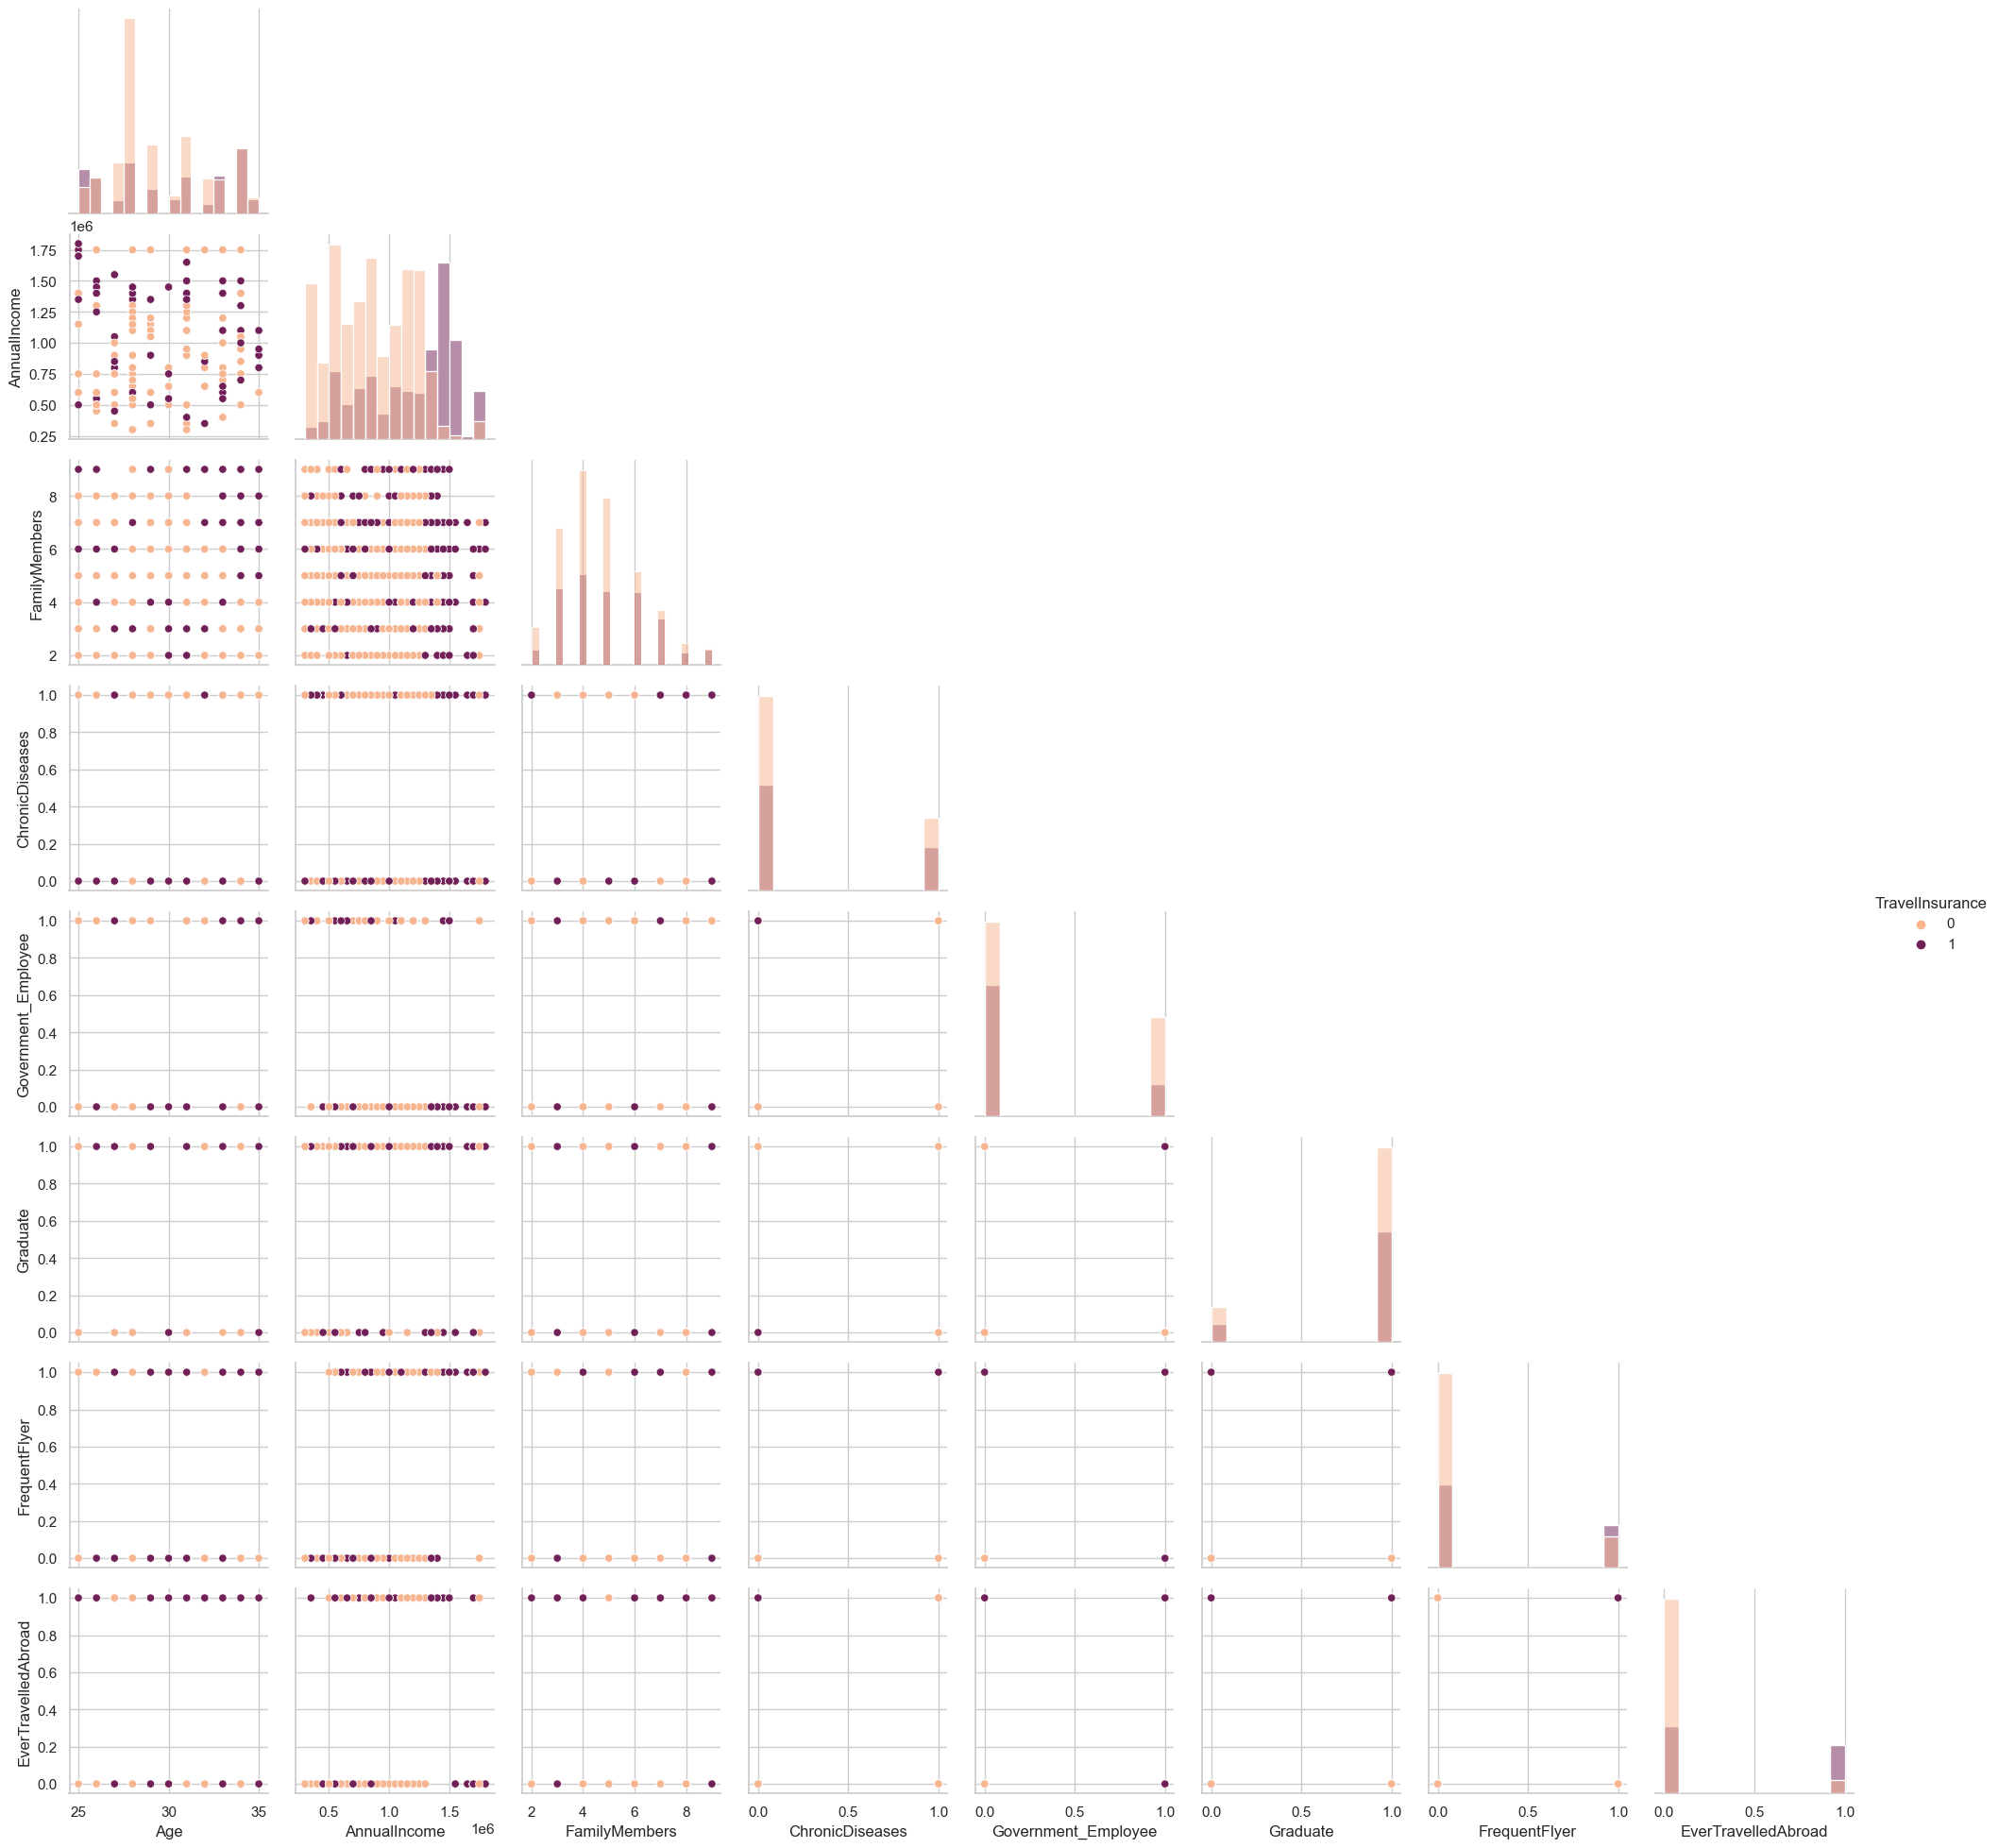

In [36]:
g = sns.PairGrid(insurance,
                 hue='TravelInsurance',
                 diag_sharey=False, corner=True,
                 palette={1: 'C1', 0: 'C5'}
                 )
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

plt.show()

* Pair plot shows that Annual income, Age, Family members are not linearly related among each other.
* Binary features don't look like a subset of any other feature (no missing points).
* TravelInsurance has somewhat of tendency with AnuualIncome, this will be investigated later.

#### Continues and Discrete Features
Checking Continues and Discrete feature distribution

Age


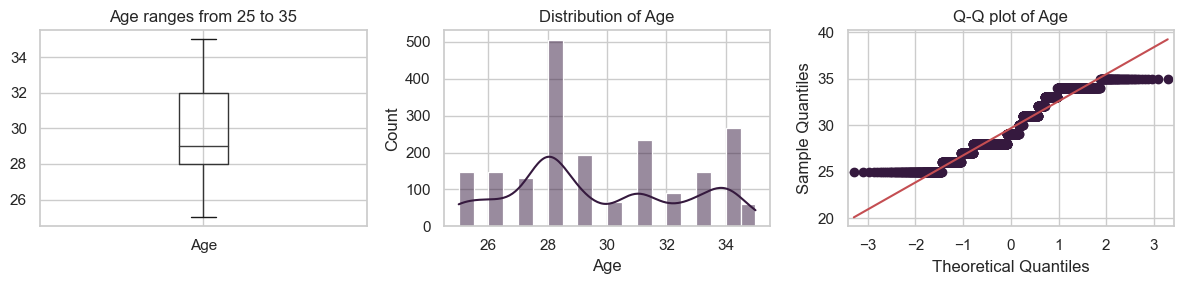

AnnualIncome


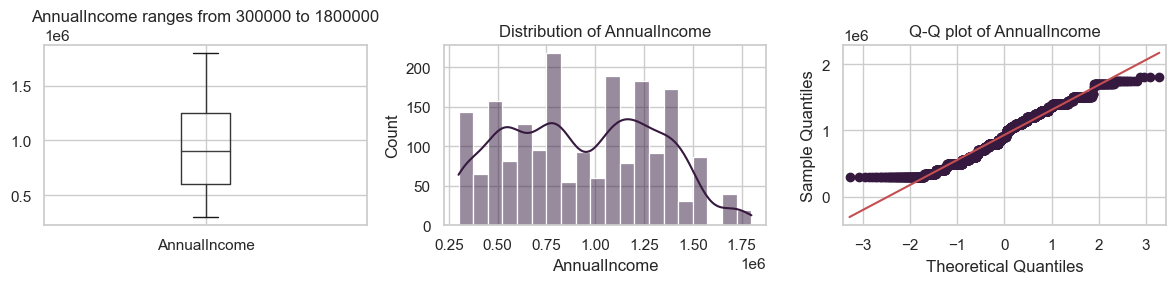

FamilyMembers


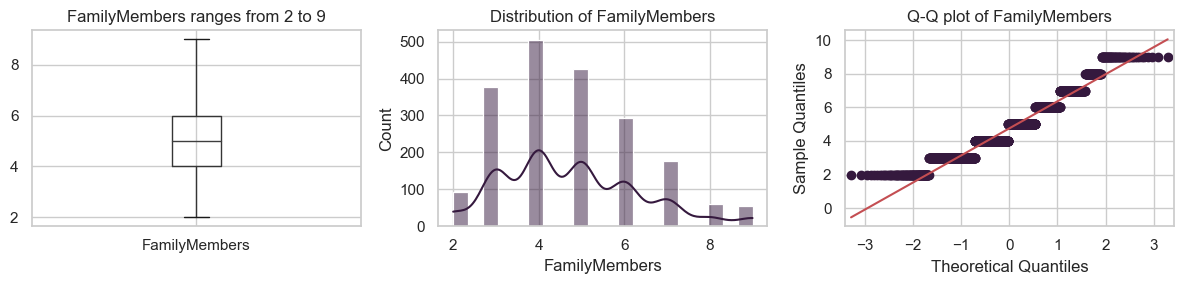

In [37]:
helpingtool.distribution_check(
    insurance[['Age', 'AnnualIncome', 'FamilyMembers']])

* Continues and Discrete features are non-normal distributed. Q-Q plot is almost on the red line (normal) and this suggest t-Student distribution.
* Majority of respondents are 29 years old, all respondents are in their 20s-30s.

#### Binary Features
Binary data is imbalanced, the respondents were mostly:
* Without ChronicDiseases
* Not buying travel insurance
* Not Government Employee
* Graduated
* Not a frequent flyer and never travelled abroad.

In [38]:
for i in binary_features:
    value_counts = insurance[i].value_counts()
    total_count = len(insurance[i])

    for value, count in value_counts.items():
        if value == 1:
            percentage = (count / total_count) * 100
            print(f"{i}: {percentage:.2f}%")

ChronicDiseases: 27.78%
TravelInsurance: 35.73%
Government_Employee: 28.69%
Graduate: 85.15%
FrequentFlyer: 20.99%
EverTravelledAbroad: 19.12%


Checking for one binary variable to be a subset of another binary variable. I.e. Cat and Animal.

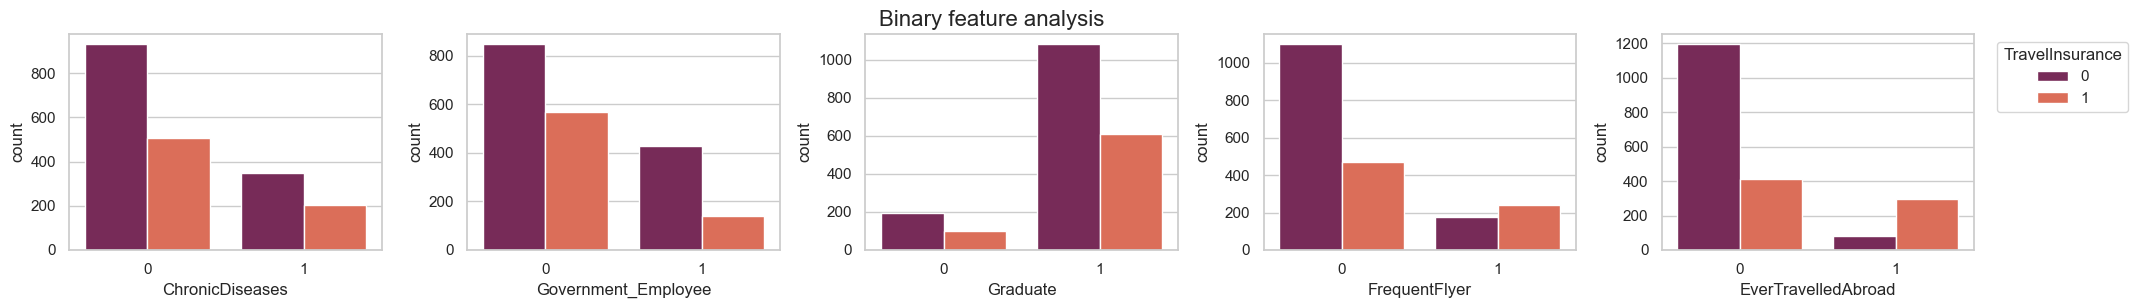

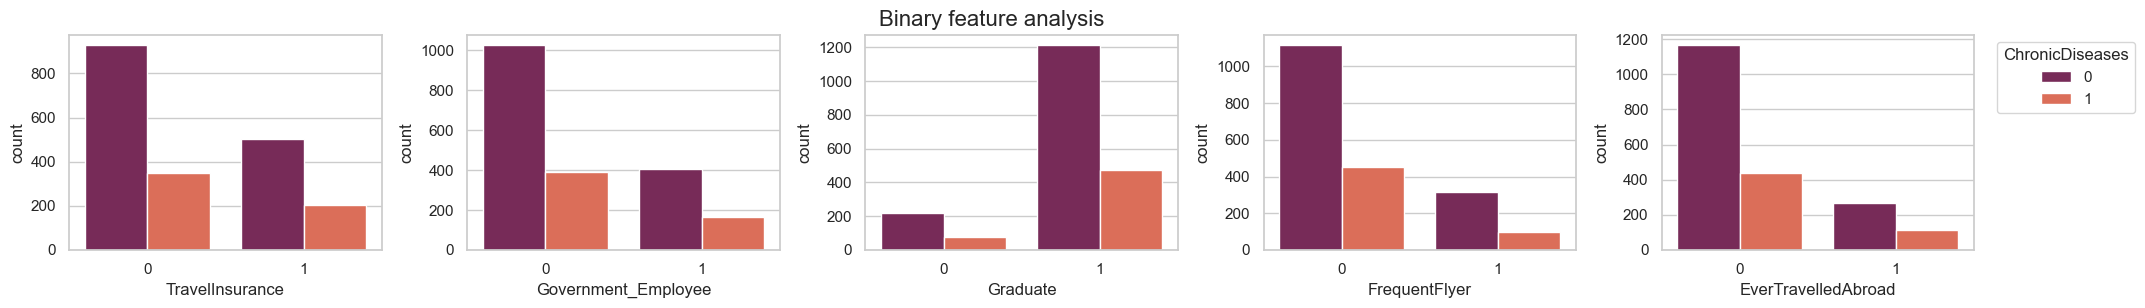

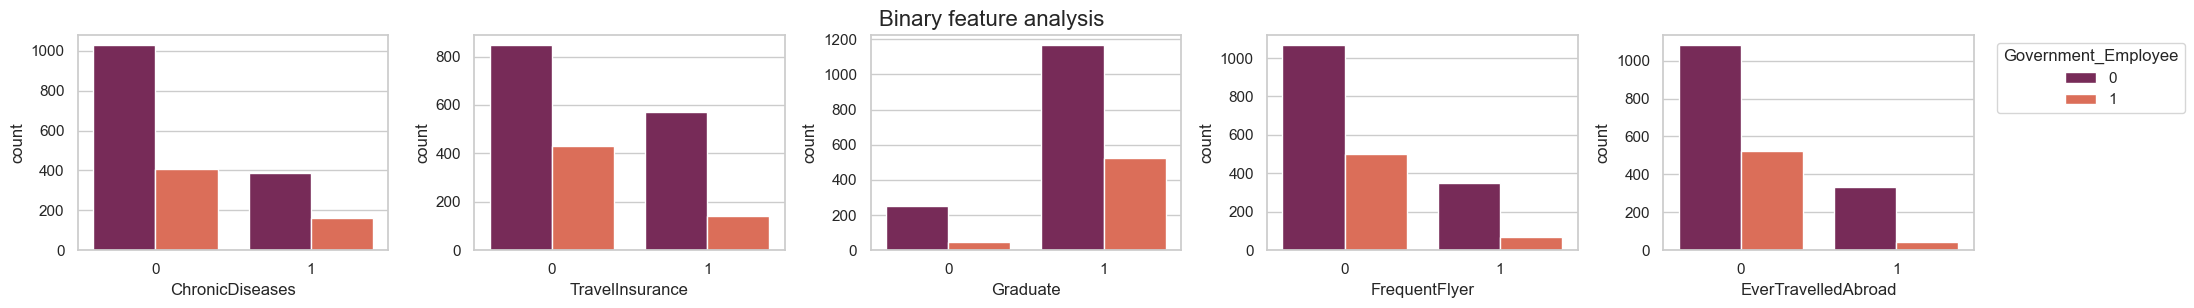

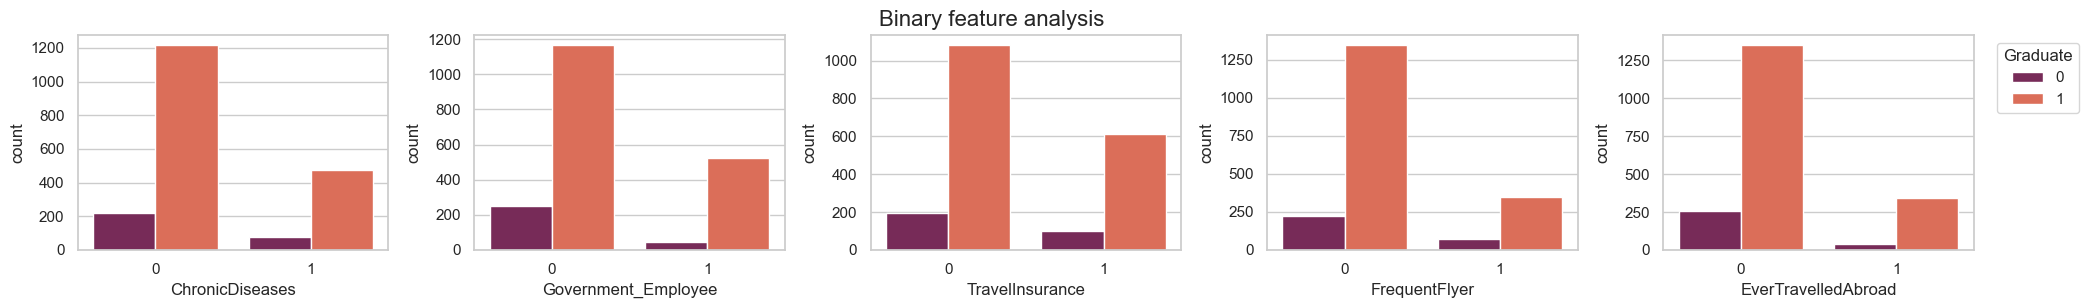

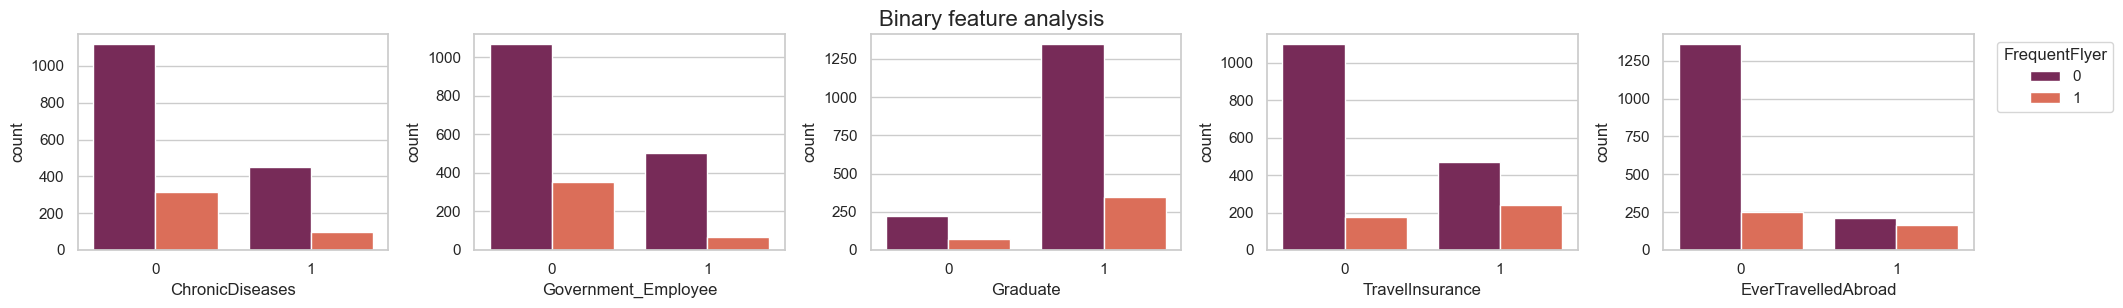

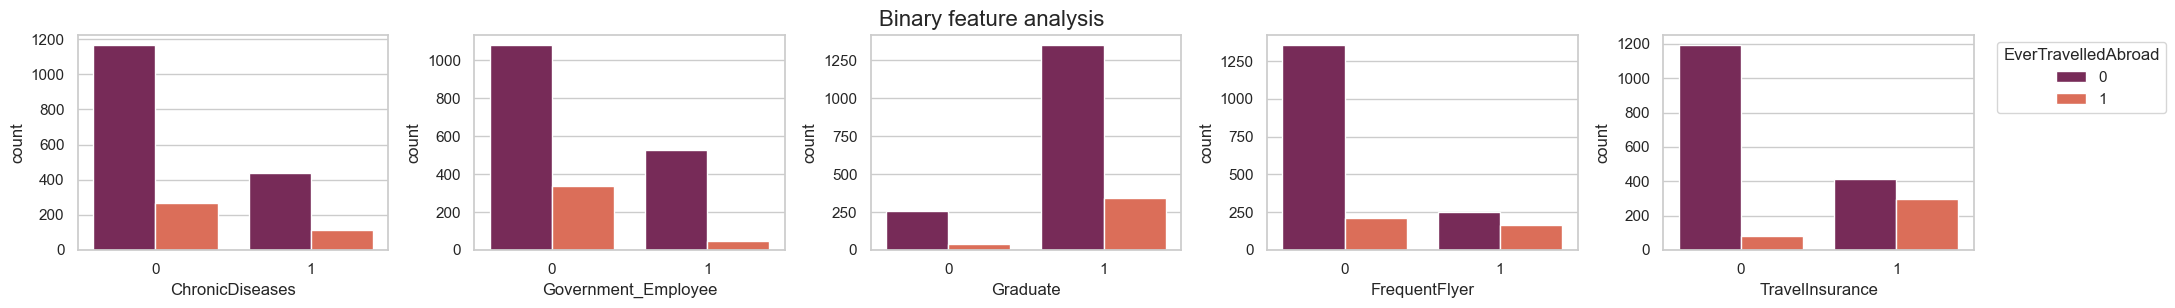

In [39]:
helpingtool.countplot_per_feature(insurance, [
                                  'ChronicDiseases', 'Government_Employee', 'Graduate', 'FrequentFlyer', 'EverTravelledAbroad'], 'TravelInsurance')
helpingtool.countplot_per_feature(insurance, [
                                  'TravelInsurance', 'Government_Employee', 'Graduate', 'FrequentFlyer', 'EverTravelledAbroad'], 'ChronicDiseases')
helpingtool.countplot_per_feature(insurance, [
                                  'ChronicDiseases', 'TravelInsurance', 'Graduate', 'FrequentFlyer', 'EverTravelledAbroad'], 'Government_Employee')
helpingtool.countplot_per_feature(insurance, [
                                  'ChronicDiseases', 'Government_Employee', 'TravelInsurance', 'FrequentFlyer', 'EverTravelledAbroad'], 'Graduate')
helpingtool.countplot_per_feature(insurance, [
                                  'ChronicDiseases', 'Government_Employee', 'Graduate', 'TravelInsurance', 'EverTravelledAbroad'], 'FrequentFlyer')
helpingtool.countplot_per_feature(insurance, [
                                  'ChronicDiseases', 'Government_Employee', 'Graduate', 'FrequentFlyer', 'TravelInsurance'], 'EverTravelledAbroad')

* No binary feature is a subset of one another,

##### Correlation Coefficient
For Correlation Coefficient Phi coefficient was chosen. It's appropriate for measuring the association between two binary variables. Similar to Pearson correlation (ranges from -1 to 1).

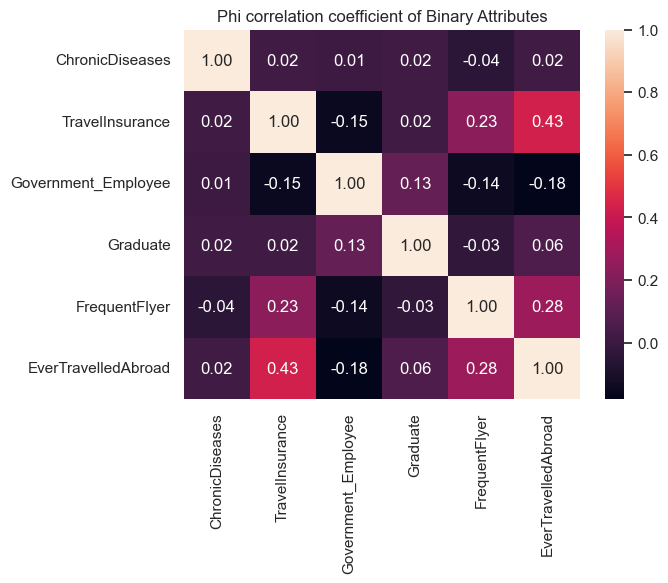

In [40]:
phi_corr_matrix = pd.DataFrame(index=binary_features, columns=binary_features)

for feature1 in binary_features:
    for feature2 in binary_features:
        phi_corr_matrix.loc[feature1, feature2] = matthews_corrcoef(
            insurance[feature1], insurance[feature2])

sns.heatmap(phi_corr_matrix.astype(float),
            annot=True, cmap='rocket', fmt=".2f")
plt.title(f'Phi correlation coefficient of Binary Attributes')
plt.show()

* Binary features are not correlated among each other, there's somewhat correlation among EverTravelledAbroad and TravelInsurance (target variable).
* India has domestic flights, this explains why EverTravelledAbroad is not a subset of FreaquentFlyer 

#### Binary vs Continues features
Previously it was showed that binary data is not balanced. Let's check for any distributions between Binary vs Continues features

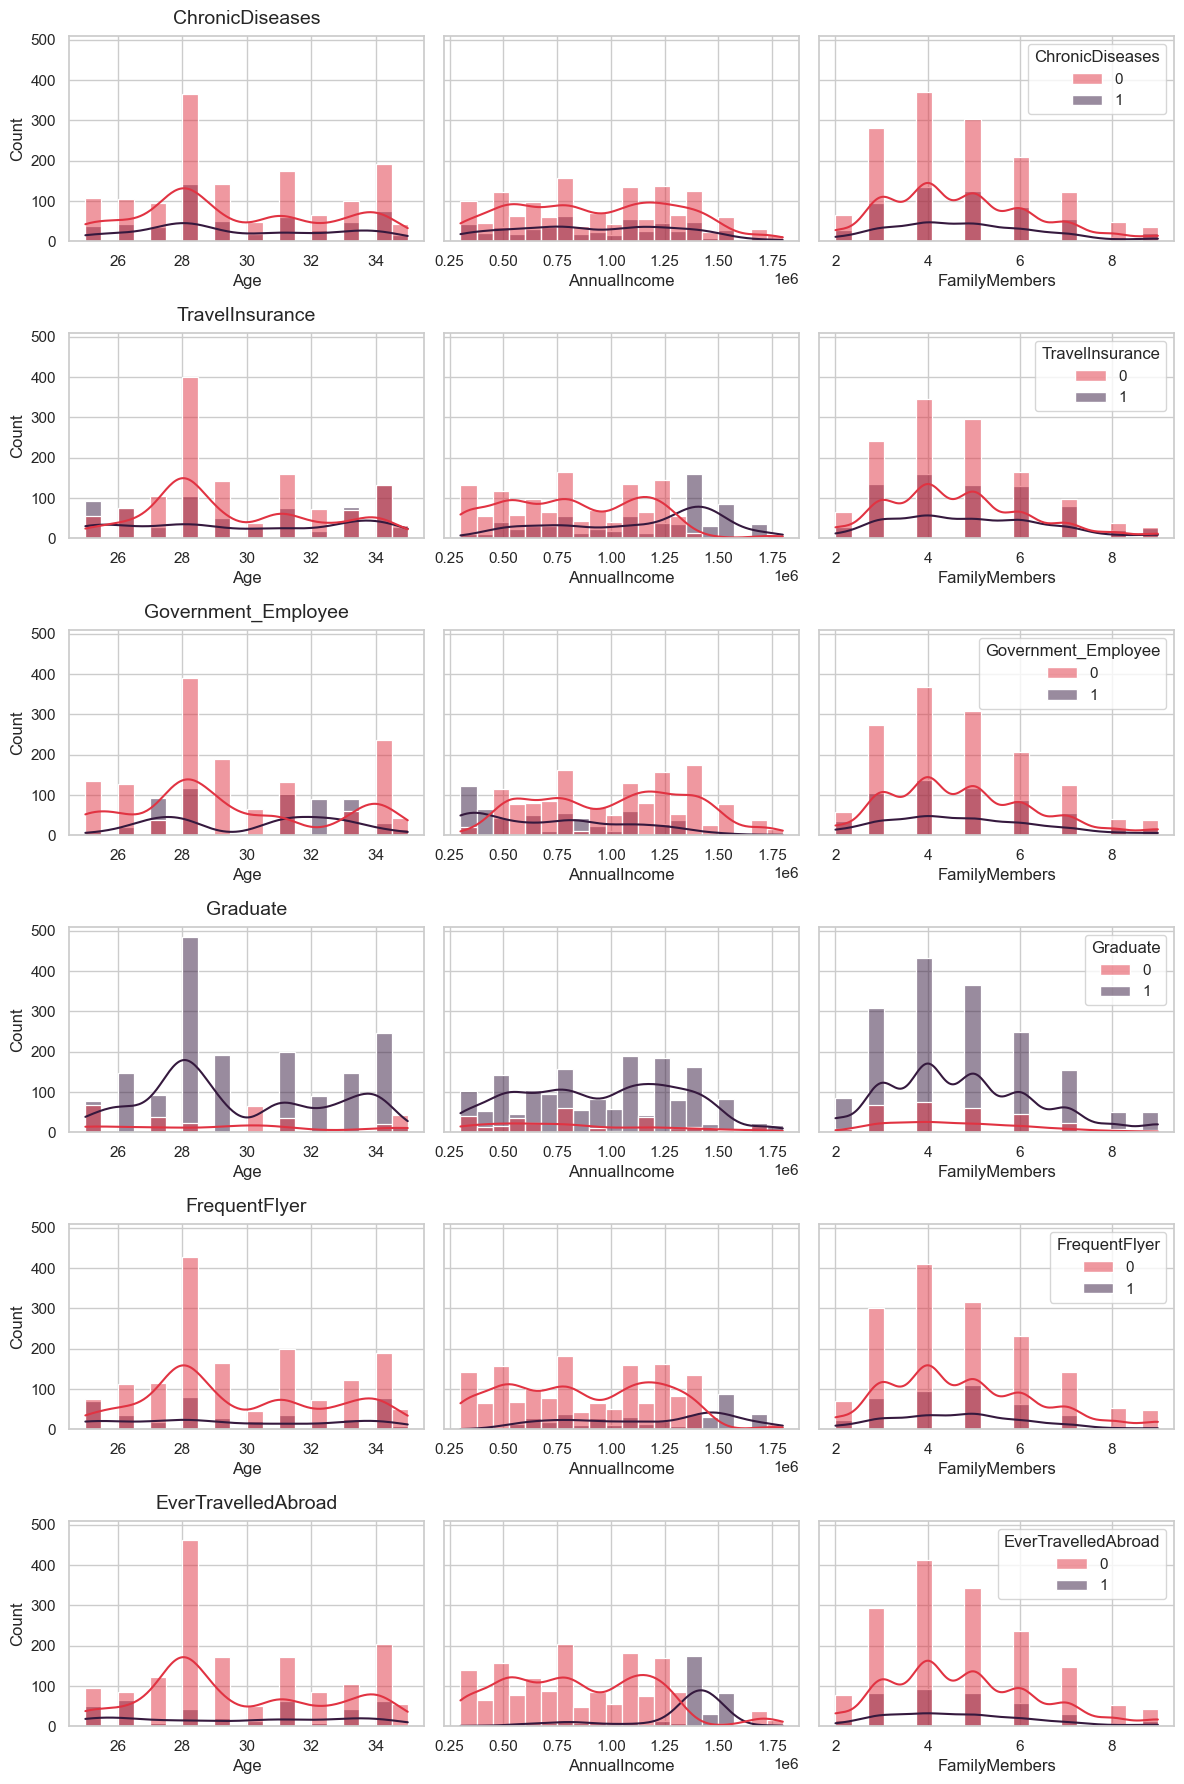

In [41]:
columns = ['Age', 'AnnualIncome', 'FamilyMembers']
hue_palette = {1: 'C0', 0: 'C9'}

fig, axes = plt.subplots(6, 3, figsize=(12, 18), sharey=True)

for i, col in enumerate(columns):
    for j, hue_var in enumerate(['ChronicDiseases', 'TravelInsurance', 'Government_Employee', 'Graduate', 'FrequentFlyer', 'EverTravelledAbroad']):
        legend = False if (i+1) % 3 != 0 else True
        sns.histplot(data=insurance, x=col, kde=True, bins=20,
                     ax=axes[j, i], hue=hue_var, palette=hue_palette, legend=legend)
        if i % 3 == 0:
            axes[j, i].set_title(f"{hue_var}", size=14, y=1.02)

plt.tight_layout()
plt.show()

* FrequentFlyer and EverTravelledAbroad seem to have similar KDE plot shapes for AnnualIncome. This will be explored in a later stage.

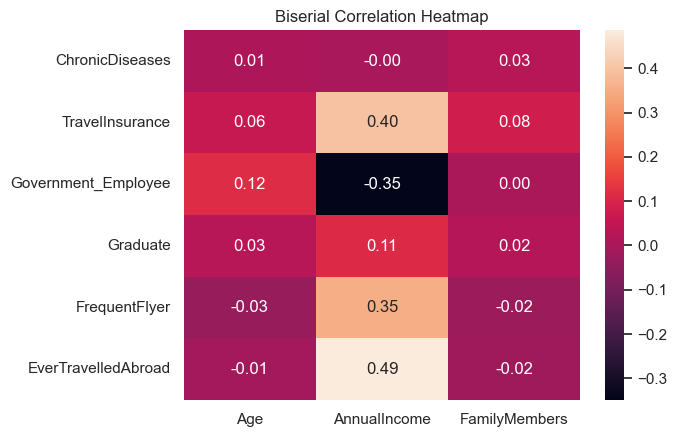

In [42]:
correlation_matrix = pd.DataFrame(
    index=binary_features, columns=continuous_features)

for binary_feature in binary_features:
    for continuous_feature in continuous_features:
        biserial_corr, _ = stats.pointbiserialr(
            insurance[binary_feature], insurance[continuous_feature])
        correlation_matrix.loc[binary_feature,
                               continuous_feature] = biserial_corr

correlation_matrix = correlation_matrix.apply(pd.to_numeric)

sns.heatmap(correlation_matrix, annot=True, cmap="rocket", fmt=".2f")
plt.title("Biserial Correlation Heatmap")
plt.show()

* AnnualIncome seams to have a some degree of linear correlation with all binary features, except ChronicDiseases.<br>
* This relationship could be attributed to non-balance of binary data (which was seen in previous graphs).

Let's check the confidence interval of 95% for AnnualIncome income

In [43]:
for feature in binary_features:
    print(feature)
    helpingtool.confidence_intervals(
        insurance['AnnualIncome'][insurance[feature] == 0], 'Continuous')
    helpingtool.confidence_intervals(
        insurance['AnnualIncome'][insurance[feature] == 1], 'Continuous')

ChronicDiseases
Confidence Interval: [913476.52, 952586.20]
Confidence Interval: [900837.06, 963293.38]
TravelInsurance
Confidence Interval: [803260.81, 839339.03]
Confidence Interval: [1105667.31, 1160811.56]
Government_Employee
Confidence Interval: [997866.61, 1034525.77]
Confidence Interval: [696111.61, 754590.15]
Graduate
Confidence Interval: [788980.79, 881527.68]
Confidence Interval: [932174.99, 967352.20]
FrequentFlyer
Confidence Interval: [846875.27, 881532.37]
Confidence Interval: [1156199.65, 1225574.93]
EverTravelledAbroad
Confidence Interval: [826909.83, 860520.16]
Confidence Interval: [1283168.06, 1335516.15]


All binary features have non overlapping Confidence intervals, when checked against AnnualIncome. But as seen in the above Biserial correlation heatmap, the relationships are not perfectly linear and Confidence intervals represent data imbalance.

### FrequentFlyer and EverTravelledAbroad combination
In Binary vs Continues plots, it was seen that FrequentFlyer and EverTravelledAbroad have similar KDE distribution on AnnualIncome. Both features have similar Confidence intervals for AnnualIncome

These features will be combined into one: Flyer_Abroad

In [44]:
insurance['Flyer_Abroad'] = insurance['FrequentFlyer'] + \
    insurance['EverTravelledAbroad']
insurance['Flyer_Abroad'] = insurance['Flyer_Abroad'].astype(int)

insurance['Flyer_Abroad'].value_counts()

0    1358
1     461
2     168
Name: Flyer_Abroad, dtype: int64

Let's examine the distribution of Flyer_Abroad against other features - the similarities for KDE plots inspired aggregation of these features.

Null Hypothesis: Flyer_Abroad value have no affect for Continues feature distribution.<br>
Alternative Hypotheses: Flyer_Abroad value have affect for Continues feature distribution.

In [45]:
for feature in continuous_features:
    helpingtool.category_Mann_Whitney_U_test(insurance, feature, 'Flyer_Abroad', 0)

p-value = 0.0007 between Age and Flyer_Abroad. Reject null hypothesis
p-value = 0.0000 between AnnualIncome and Flyer_Abroad. Reject null hypothesis
p-value = 0.4236 between FamilyMembers and Flyer_Abroad. Fail to reject null hypothesis


In [46]:
for feature in continuous_features:
    print(feature)
    helpingtool.confidence_intervals(
        insurance[feature][insurance['Flyer_Abroad'] == 0], 'Continuous')
    helpingtool.confidence_intervals(
        insurance[feature][insurance['Flyer_Abroad'] != 0], 'Continuous')

Age
Confidence Interval: [29.64, 29.93]
Confidence Interval: [29.10, 29.60]
AnnualIncome
Confidence Interval: [789300.24, 823880.91]
Confidence Interval: [1179011.51, 1231322.35]
FamilyMembers
Confidence Interval: [4.69, 4.87]
Confidence Interval: [4.57, 4.82]


People who either travel or been abroad:
* overlap in age, family members with the rest of population
* Have higher income than 11.7k Annually

Let's examine the rest of the features:

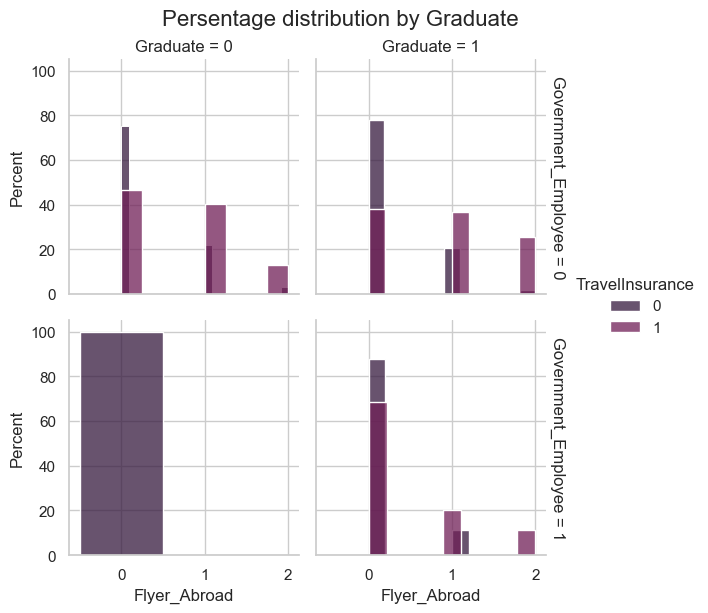

In [47]:
g = sns.FacetGrid(insurance, col="Graduate", row="Government_Employee", hue='TravelInsurance', margin_titles=True
                  )
g.map_dataframe(sns.histplot, x='Flyer_Abroad', multiple="stack",
                common_norm=True, element='bars', stat='percent')
g.add_legend()
g.figure.suptitle(f"Persentage distribution by Graduate", size=16, y=1.02)
plt.show()

* Non graduates and government employees never buy travel insurance.
* Graduated, non government employees, who identify as FrequentFlyer and EverTravelledAbroad - a sure hit for Travel insurance.

In [48]:
for feature in ['ChronicDiseases', 'TravelInsurance', 'Government_Employee', 'Graduate']:
    helpingtool.chi_statistics_duplicated(
        insurance[insurance['Flyer_Abroad'] == 0], insurance[insurance['Flyer_Abroad'] != 0], feature)

ChronicDiseases:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): -0.020. Small Effect Size
TravelInsurance:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): 0.382. Medium Effect Size
Government_Employee:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): -0.206. Medium Effect Size
Graduate:
Chi-Squared Test Statistic: 0.0.
p-value = 1.00. Fail to reject null hypothesis
Effect Size (Cohen's d): 0.006. Small Effect Size


Binary values are not affected by combining of Flying attributes

# Conclusion

Duplicate values are:
* Slightly younger population
* Less family member respondents

Features are not linearly related among each other
Data is imbalanced, the respondents were mostly:
* 29 years old
* Without ChronicDiseases
* Not buying travel insurance
* Not Government Employee
* Graduated
* Not a frequent flyer and never travelled abroad.

Flying habits:
* FrequentFlyer and EverTravelledAbroad tell related information on TravelInsurance, these features were aggregated.
* Non graduates and government employees never buy travel insurance.
* Graduated, non government employees, who identify as FrequentFlyer and EverTravelledAbroad - a sure hit for Travel insurance.
